# Initial explore of the India Data

In [93]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

In [94]:
from scripts.utils import get_data_path
from src.engineer import Engineer

In [95]:
from src.utils import get_ds_mask

# Open data

In [96]:
data_dir = get_data_path()

In [97]:
e = Engineer(data_dir)
dynamic_ds = e.engineer_class._make_dataset(static=False)
static_ds = e.engineer_class._make_dataset(static=True)

Processing /cats/datastore/data/interim/VCI_preprocessed/data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_1_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_2_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_3_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_4_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/potential_evaporation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/total_precipitation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/2m_temperature_data_india.nc
Processing /cats/datastore/data/interi

In [98]:
mask = get_ds_mask(dynamic_ds['e'])

dynamic_ds['tp'] = dynamic_ds['tp'].where(~mask)
dynamic_ds['VCI'] = dynamic_ds['VCI'].where(~mask)
static_ds['slt'] = static_ds['slt'].where(~mask)

In [99]:
static_ds = static_ds.drop("expver") if "expver" in static_ds.coords else static_ds

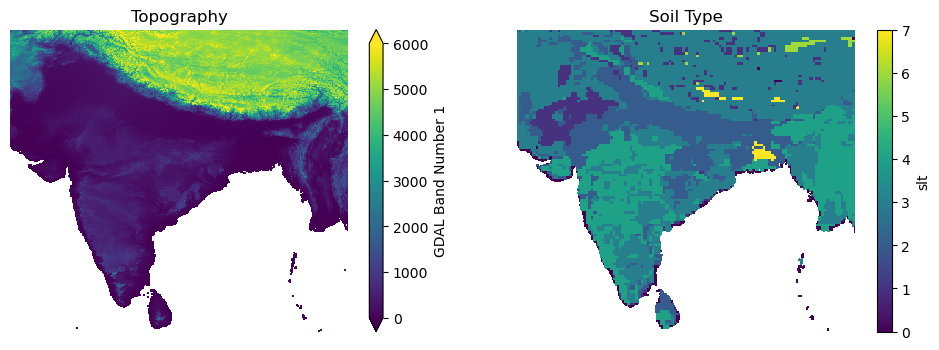

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
kwargs = {"topography": dict(vmin=0, vmax=6000), "slt": dict()}
[static_ds[v].plot(ax=axs[i], **kwargs[v]) for (i, v) in enumerate(static_ds.data_vars)];
axs[0].set_title("Topography")
axs[0].axis('off')
axs[1].set_title("Soil Type")
axs[1].axis('off');

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


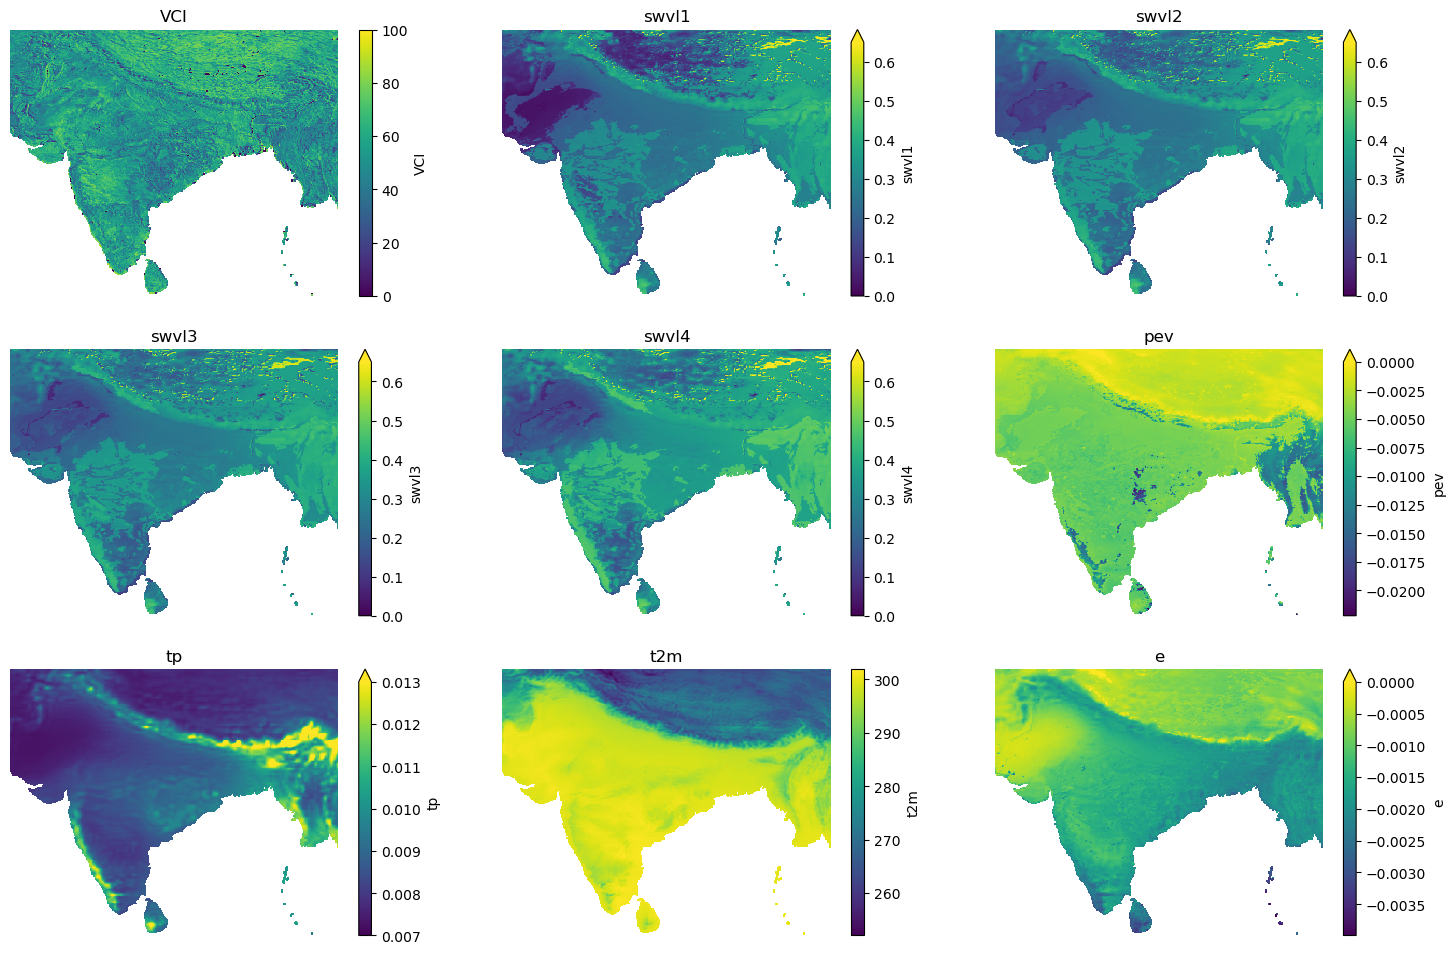

In [101]:
fig, axs = plt.subplots(3,3, figsize=(6*3, 4*3))
kwargs = {
    "VCI": dict(vmin=0, vmax=100), 
    "swvl1": dict(vmin=0, vmax=0.65),
    "swvl2": dict(vmin=0, vmax=0.65),
    "swvl3": dict(vmin=0, vmax=0.65),
    "swvl4": dict(vmin=0, vmax=0.65),
    "tp": dict(vmin=0.007, vmax=0.013),
    "t2m": dict(vmin=None, vmax=None),
    "pev": dict(vmin=None, vmax=0),
    "e": dict(vmin=None, vmax=0),
}

non_forecast_vars = [v for v in dynamic_ds.data_vars if ("std" not in v) and ("mean" not in v)]
for (i, v) in enumerate(non_forecast_vars):
    ax = axs[np.unravel_index(i, (3,3))]
    dynamic_ds[v].mean(dim='time').plot(ax=ax, **kwargs[v])
    ax.set_title(v)
    ax.axis('off')

# Forecast Vars

In [102]:
forecast_vars = [v for v in dynamic_ds.data_vars if ("std" in v) or ("mean" in v)]
forecast_vars = sorted(forecast_vars)

In [103]:
# mask the missing data
for v in forecast_vars:
    dynamic_ds[v] = dynamic_ds[v].where(~mask)

In [104]:
evap_std_scale = float(
    dynamic_ds[[v for v in forecast_vars if "erate_std" in v]].quantile(q=0.75).to_array().max().values
)
precip_std_scale = float(
    dynamic_ds[[v for v in forecast_vars if "tprate_std" in v]].quantile(q=0.75).to_array().max().values
)
t2m_std_scale = float(
    dynamic_ds[[v for v in forecast_vars if "t2m_std" in v]].quantile(q=0.75).to_array().max().values
)
evap_mean_scale = float(
    dynamic_ds[[v for v in forecast_vars if "erate_mean" in v]].quantile(q=0.75).to_array().max().values
)
precip_mean_scale = float(
    dynamic_ds[[v for v in forecast_vars if "tprate_mean" in v]].quantile(q=0.75).to_array().max().values
)
t2m_mean_scale = float(
    dynamic_ds[[v for v in forecast_vars if "t2m_mean" in v]].quantile(q=0.75).to_array().max().values
)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


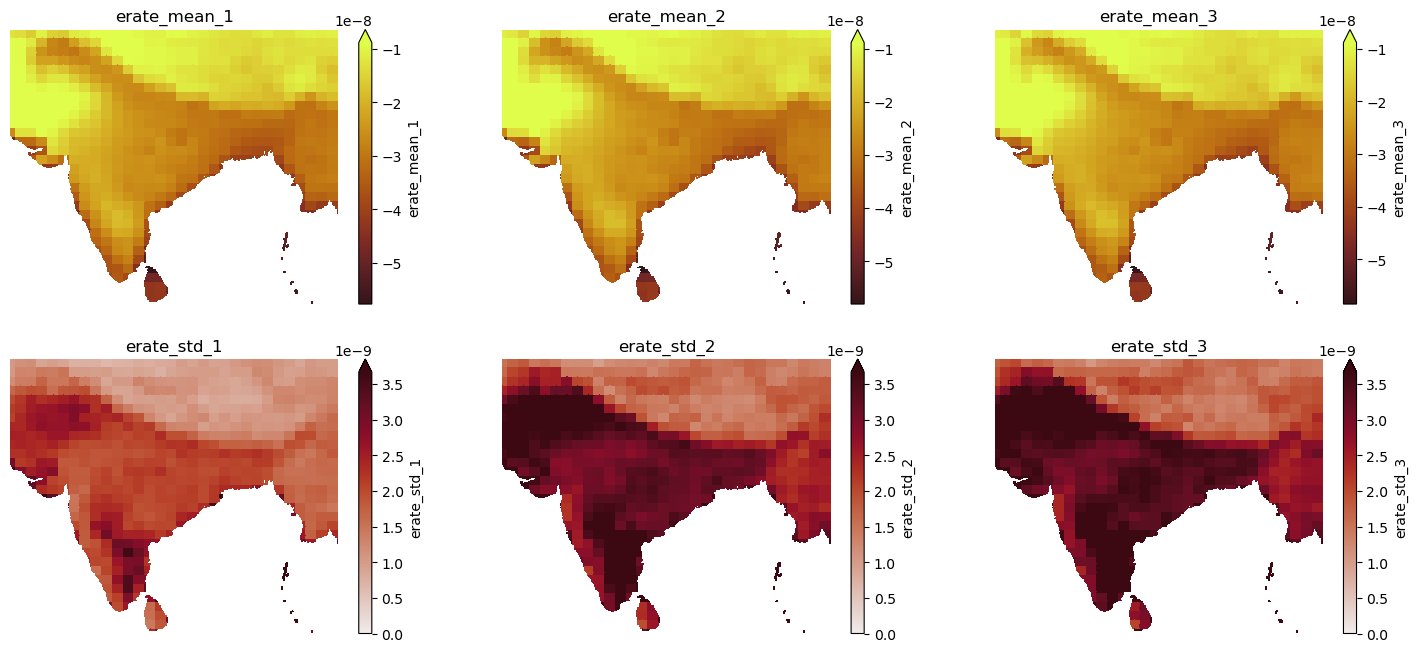

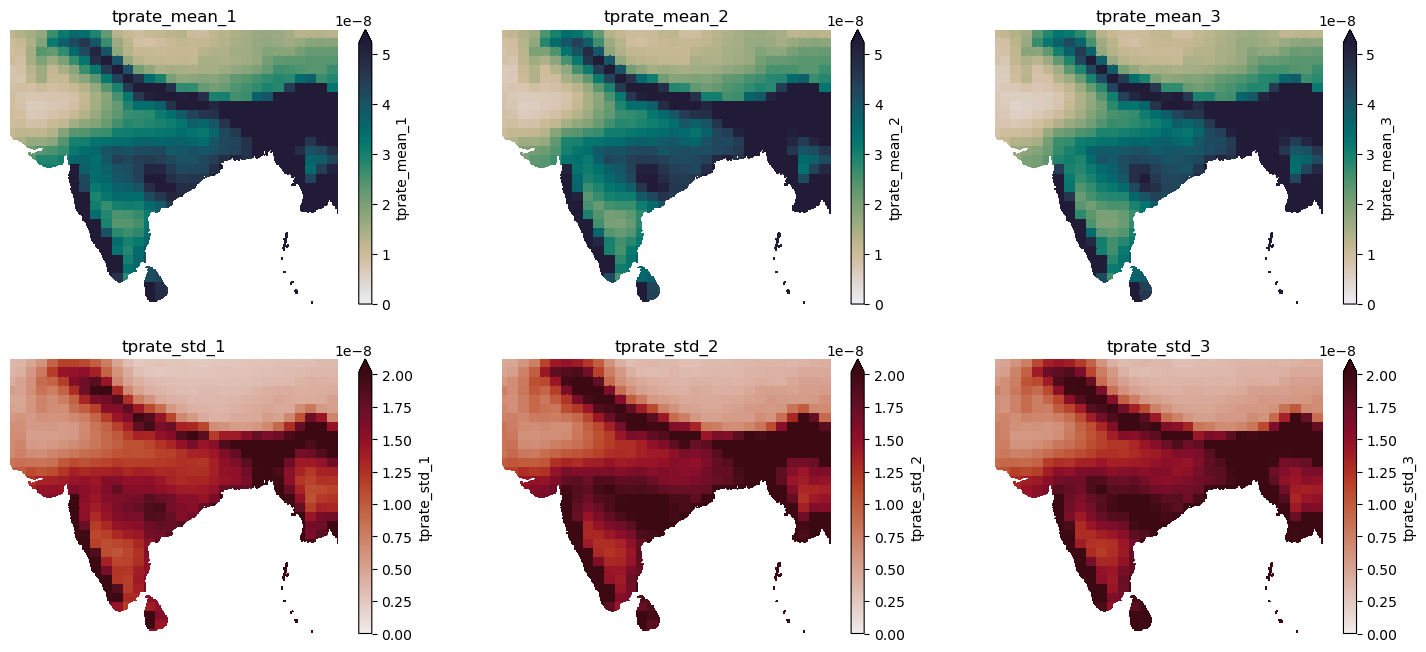

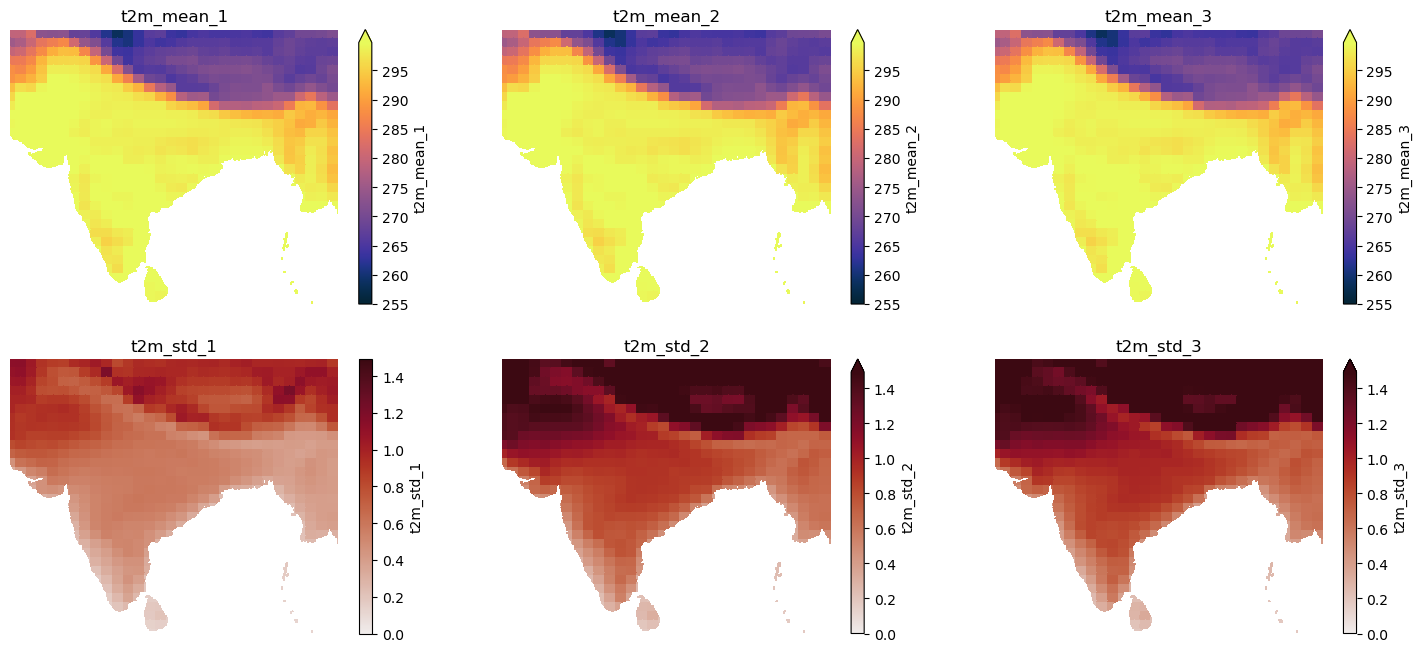

In [112]:
for var in ["erate", "tprate", "t2m"]:
    fig, axs = plt.subplots(2, 3, figsize=(6*3, 4*2))
    for (i, v) in enumerate([v for v in forecast_vars if var in v]):
        ax = axs[np.unravel_index(i, (2,3))]
        
        # get color kwargs
        if "erate_std" in v:
            kwargs = {"vmin": 0, "vmax": evap_std_scale, "cmap": "cmo.amp"}
        if "tprate_std" in v:
            kwargs = {"vmin": 0, "vmax": precip_std_scale, "cmap": "cmo.amp"}
        if "t2m_std" in v:
            kwargs = {"vmin": 0, "vmax": t2m_std_scale, "cmap": "cmo.amp"}
        elif "erate_mean" in v:
            kwargs = {"vmin": None, "vmax":evap_mean_scale, "cmap": "cmo.solar"}
        elif "t2m_mean" in v:
            kwargs = {"vmin": 255, "vmax": t2m_mean_scale, "cmap": "cmo.thermal"}
        elif "tprate_mean" in v:
            kwargs = {"vmin": 0, "vmax": precip_mean_scale, "cmap": "cmo.rain"}
        
        dynamic_ds[v].mean(dim='time').plot(ax=ax, **kwargs)
        ax.set_title(v)
        ax.axis('off')   

# Plot for an individual Time point

# How accurate are these forecasts?

In [113]:
# fig, axs = plt.subplots(6, 3, figsize=(6*3, 4*6))

# for (i, v) in enumerate(forecast_vars):
#     ax = axs[np.unravel_index(i, (6,3))]
#     if "erate_std" in v:
#         kwargs = {"vmin": 0, "vmax": evap_std_scale, "cmap": "cmo.amp"}
#     if "tprate_std" in v:
#         kwargs = {"vmin": 0, "vmax": precip_std_scale, "cmap": "cmo.amp"}
#     if "t2m_std" in v:
#         kwargs = {"vmin": 0, "vmax": t2m_std_scale, "cmap": "cmo.amp"}
#     elif "erate_mean" in v:
#         kwargs = {"vmin": None, "vmax":evap_mean_scale, "cmap": "cmo.solar"}
#     elif "t2m_mean" in v:
#         kwargs = {"vmin": 255, "vmax": t2m_mean_scale, "cmap": "cmo.thermal"}
#     elif "tprate_mean" in v:
#         kwargs = {"vmin": 0, "vmax": precip_mean_scale, "cmap": "cmo.rain"}
        
#     dynamic_ds[v].mean(dim='time').plot(ax=ax, **kwargs)
#     ax.set_title(v)
#     ax.axis('off')

# Open the boundaries ?

In [106]:
[d.name for d in (data_dir / "analysis/boundaries_preprocessed").iterdir()]

['state_l1_india.nc', 'district_l2_india.nc']

In [107]:
district_nc = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")
state_nc = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")

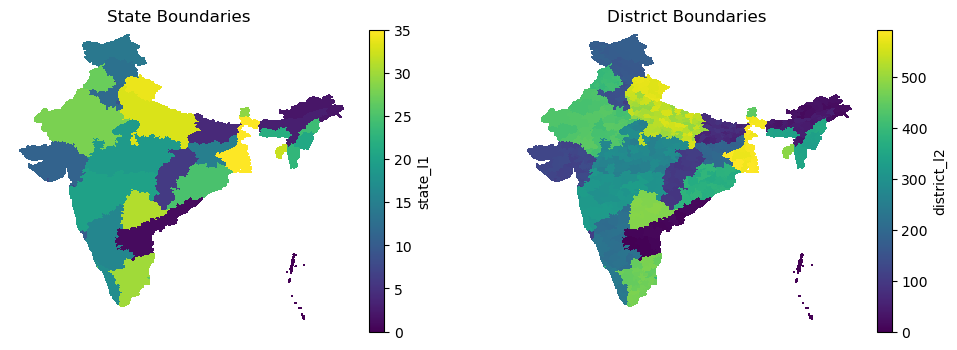

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

state_nc["state_l1"].plot(ax=axs[0])
axs[0].set_title("State Boundaries")
axs[0].axis('off')
district_nc["district_l2"].plot(ax=axs[1])
axs[1].set_title("District Boundaries")
axs[1].axis('off');

# How did the initial forecasts go?

In [134]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis import spatial_rmse, spatial_r2

In [119]:
X_train, y_train = read_train_data(data_dir);
X_test, y_test = read_test_data(data_dir);

/home/tommy/ml_drought/src/analysis/evaluation.py:157: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  train_ds = xr.open_mfdataset(data_paths).sortby("time").compute()
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/home/tommy/ml_drought/src/analysis/evaluation.py:157: Fut

In [131]:
_, lstm_da = read_pred_data(data_dir=data_dir, model="rnn")
_, bline_da = read_pred_data(data_dir=data_dir, model="previous_month")
_, ln_da = read_pred_data(data_dir=data_dir, model="linear_network")

In [166]:
test_da = y_test["VCI"].transpose("time", "lat", "lon")
test_da = test_da.sel(lat=lstm_da.lat, lon=lstm_da.lon, time=lstm_da.time)

lstm_rmse = spatial_rmse(test_da, lstm_da.transpose("time", "lat", "lon"))
lstm_r2 = spatial_r2(test_da, lstm_da.transpose("time", "lat", "lon"))

bline_rmse = spatial_rmse(test_da, bline_da.transpose("time", "lat", "lon"))
bline_r2 = spatial_r2(test_da, bline_da.transpose("time", "lat", "lon"))

ln_rmse = spatial_rmse(test_da, ln_da.transpose("time", "lat", "lon"))
ln_r2 = spatial_r2(test_da, ln_da.transpose("time", "lat", "lon"))

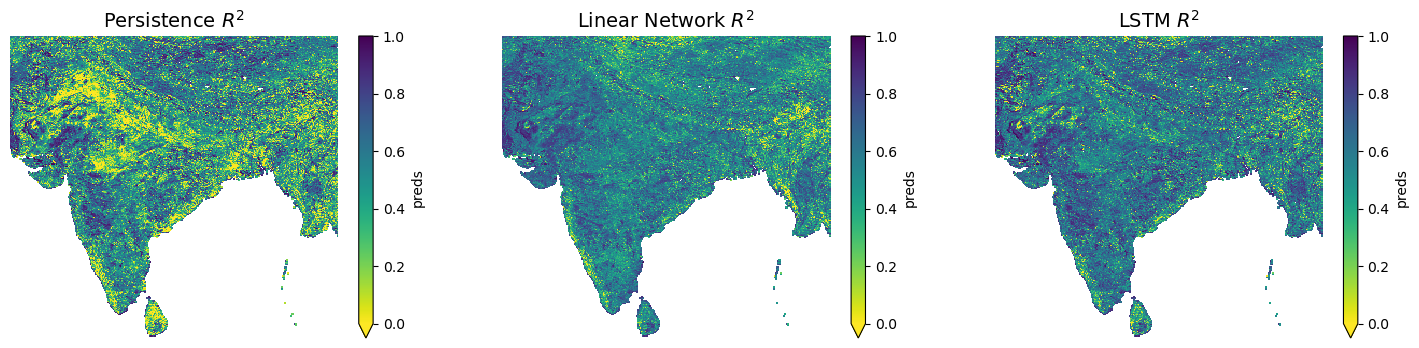

In [168]:
names = ["Persistence", "Linear Network", "LSTM"]
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, preds in enumerate([bline_r2, ln_r2, lstm_r2]):
    ax = axs[i]  # np.unravel_index(i, (1, 3)) 
    preds.plot(ax=ax, vmin=0, vmax=1, cmap="viridis_r")
    ax.set_title(f"{names[i]} $R^2$", size=14)
    ax.axis('off')

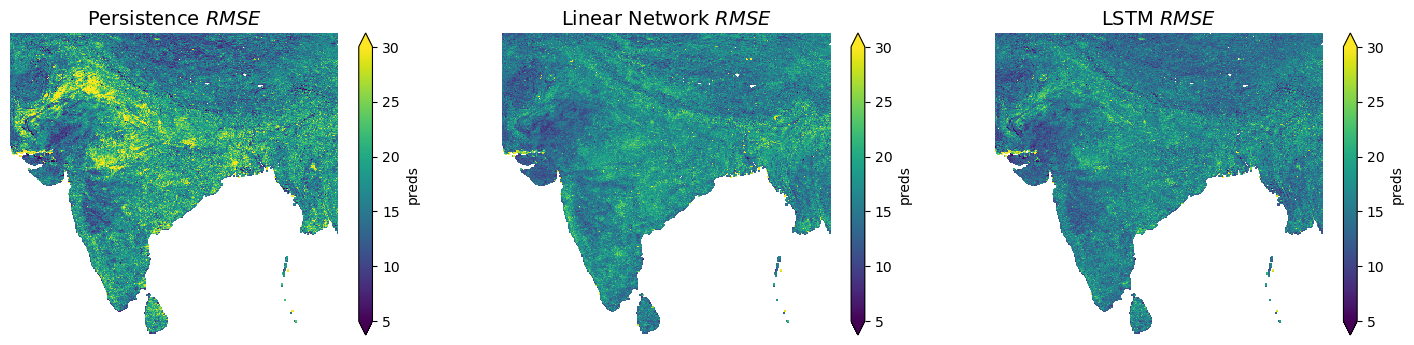

In [176]:
names = ["Persistence", "Linear Network", "LSTM"]
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, preds in enumerate([bline_rmse, ln_rmse, lstm_rmse]):
    ax = axs[i]  # np.unravel_index(i, (1, 3)) 
    preds.plot(ax=ax, vmin=5, vmax=30, cmap="viridis")
    ax.set_title(f"{names[i]} $RMSE$", size=14)
    ax.axis('off')